In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime as dt, timedelta
from prometheus_api_client import PrometheusConnect,  MetricSnapshotDataFrame, MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime

from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt

PROM_URL = "http://vmquery"

In [2]:
## 1. Adquisición de Datos
# Conexion a nuestra instancia de Prometheus

promConn = PrometheusConnect(url = PROM_URL, disable_ssl=True)

# Obtener DF Metrics Timeseries
def metric_query(labels, start_time, end_time, query):
    metric_data = promConn.get_metric_range_data(
        query,
        label_config=labels,
        start_time = start_time,
        end_time = end_time,
    )

    return MetricRangeDataFrame(metric_data)

# Dividir el DF (Metrics Timeseries) en datos de entrenamiento y de test
def split_df_data(df_datos, ratio = 0.2):
    size = int(len(df_datos) * (1-float(ratio)))
    train, test = df_datos[0:size], df_datos[size:len(df_datos)]
    return train, test

In [3]:
# Consulta las metricas
labels = { 'job' : 'node-exporter', 'instance': '10.44.0.3:9100', 'mountpoint' : '/'}
start_time = parse_datetime("14d")
end_time = parse_datetime("now")
query = 'node_filesystem_avail_bytes'
    
df_prom = metric_query(labels, start_time, end_time, query)

In [4]:
# 2. Inspeccion y preparacion de los datos

# Seleccionamos las columnas que necesitamos para el analisis
df = df_prom[['value']].copy()
df = df.set_index(df_prom.index)

df = df.resample('60T').mean()

# Dividimos nuestros datos para entrenar y test
df_train, df_test = split_df_data(df)

In [5]:
# 3. Modelado

def SARIMA(df_datos, steps, sfrequency):
    
    model = SARIMAX(df_datos, order=(1, 1, 2), seasonal_order=(2,2,2,sfrequency), enforce_stationarity = True, enforce_invertibility = False)
    results = model.fit(dsip=-1)

    # Realizar el pronóstico para los próximos 7 días
    forecast = results.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()

    return results, pd.DataFrame(forecast_values, index = confidence_intervals.index), confidence_intervals


In [6]:
model, forecast, confidence_intervals = SARIMA(df, 96, 12) # con freq 12 anduvo

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06247D+01    |proj g|=  3.72624D-01

At iterate    5    f=  2.03768D+01    |proj g|=  4.14218D-03

At iterate   10    f=  2.03761D+01    |proj g|=  2.38881D-02

At iterate   15    f=  2.03699D+01    |proj g|=  5.85181D-02

At iterate   20    f=  2.03675D+01    |proj g|=  1.17472D-02

At iterate   25    f=  2.03674D+01    |proj g|=  3.54309D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8    

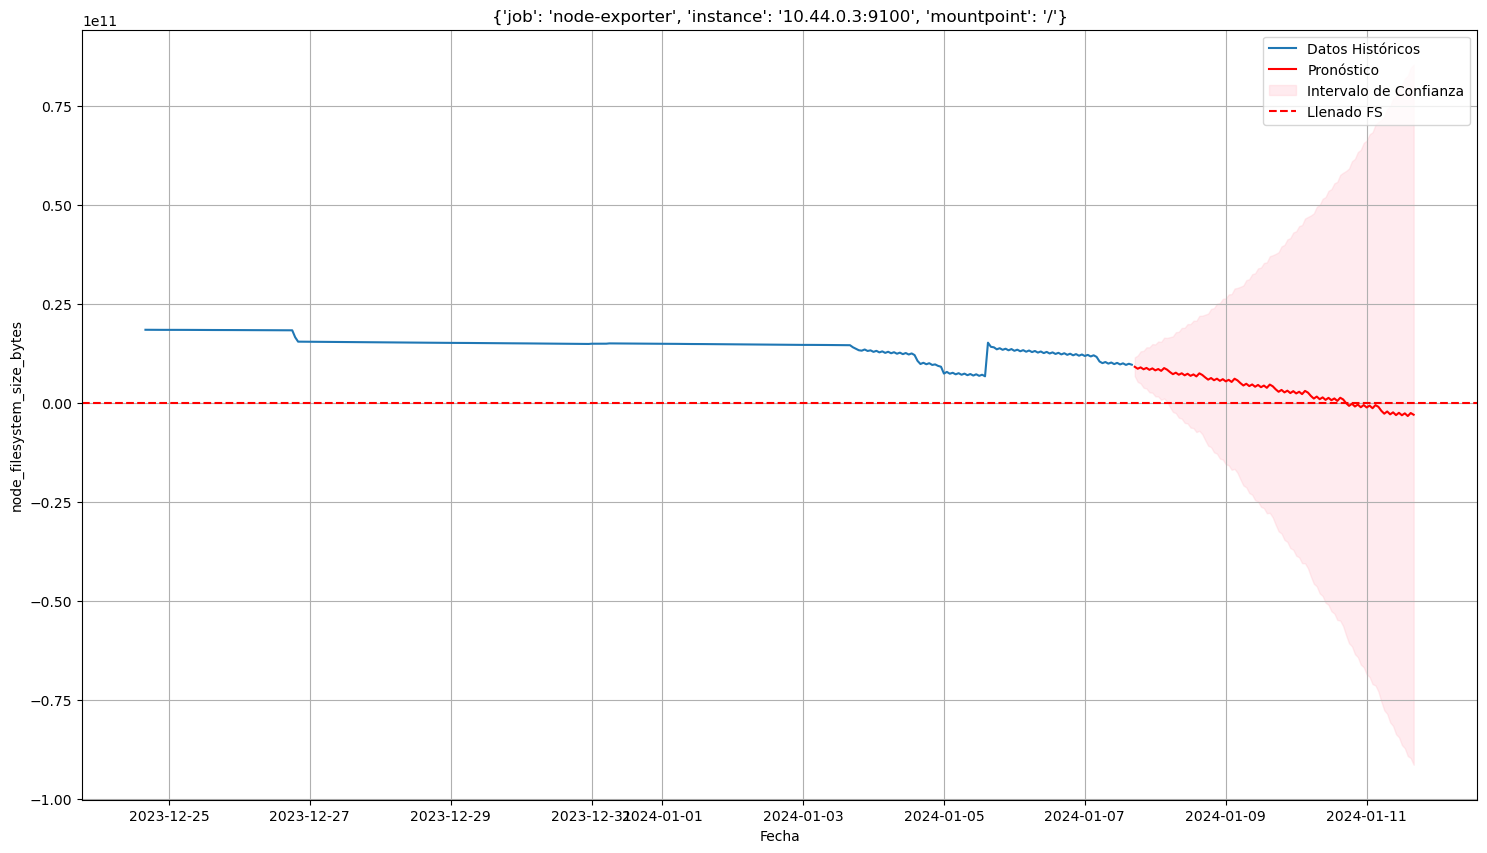

In [34]:
## 4. Visualización de los datos
# Datos históricos
plt.figure(figsize=(18, 10))
plt.plot(df, label='Datos Históricos')

# Pronóstico
plt.plot(forecast, color='red', label='Pronóstico')

# Intervalo de confianza
plt.fill_between(
    confidence_intervals.index, 
    confidence_intervals['lower value'],  
    confidence_intervals['upper value'], 
    color='pink', alpha=0.3, label='Intervalo de Confianza'
)

# Umbral
plt.axhline(y=0, color='red', linestyle='--', label='Llenado FS')

plt.xlabel('Fecha')
plt.ylabel(query)
plt.title(labels)
plt.legend()
plt.grid(True)
plt.show()

In [9]:
df

,value
timestamp,
2023-12-24 16:00:00,1.842095e+10
2023-12-24 17:00:00,1.841297e+10
2023-12-24 18:00:00,1.840693e+10
2023-12-24 19:00:00,1.840263e+10
2023-12-24 20:00:00,1.840535e+10
...,...
2024-01-07 12:00:00,9.665569e+09
2024-01-07 13:00:00,9.951439e+09
2024-01-07 14:00:00,9.546106e+09


In [28]:
# forecast.index[forecast['predicted_mean'] <= 0].tolist()

menor_cero = forecast.loc[forecast.index == "2024-01-10 17:00:00"]
print(menor_cero)

                     predicted_mean
2024-01-10 17:00:00   -9.883629e+07
